<a href="https://colab.research.google.com/github/Kuakun55/Stock-price-predicton-Tsla/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import yfinance as yf

In [ ]:
# ตั้งค่าวันเริ่มต้นและวันสิ้นสุดในการดึงข้อมูล
start_date = "2010-06-29"
end_date = "2020-02-03"

In [ ]:
# ดึงข้อมูลราคาหุ้น
tsla_data = yf.download("MSFT", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# แสดงตารางข้อมูล
print(tsla_data.head())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2010-06-29  24.129999  24.200001  23.110001  23.309999  17.956203  119882100
2010-06-30  23.299999  23.680000  22.950001  23.010000  17.725107   81050500
2010-07-01  23.090000  23.320000  22.730000  23.160000  17.840656   92239400
2010-07-02  23.360001  23.480000  23.049999  23.270000  17.925398   62485100
2010-07-06  23.700001  24.090000  23.580000  23.820000  18.349073   73592000


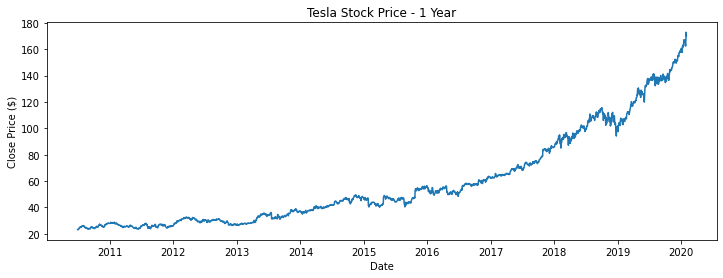

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(tsla_data['Close'])
plt.title('Tesla Stock Price - 1 Year')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()

In [ ]:
data = tsla_data.filter(['Close']).values

In [ ]:
# แบ่งข้อมูลเป็น train set และ test set
training_data_len = int(np.ceil(len(data) * 0.8))
test_data_len = len(data) - training_data_len
train_data = data[0:training_data_len,:]
test_data = data[training_data_len:len(data),:]

scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train_data)

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i+time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, Y_train = create_dataset(train_data_scaled, time_step)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# สร้างโมเดล LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
# Compile และ Train โมเดล
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=50, batch_size=32)

last_60_days = tsla_data['Close'][-60:].values
last_60_days_scaled = scaler.transform(last_60_days.reshape(-1, 1))

X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model

Epoch 1/50
59/59 [==============================] - 17s 135ms/step - loss: 8.5101e-04
Epoch 2/50
59/59 [==============================] - 8s 128ms/step - loss: 3.2647e-04
Epoch 3/50
59/59 [==============================] - 6s 104ms/step - loss: 3.0302e-04
Epoch 4/50
59/59 [==============================] - 5s 87ms/step - loss: 3.4575e-04
Epoch 5/50
59/59 [==============================] - 6s 107ms/step - loss: 2.9762e-04
Epoch 6/50
59/59 [==============================] - 5s 85ms/step - loss: 2.6744e-04
Epoch 7/50
59/59 [==============================] - 6s 103ms/step - loss: 2.5203e-04
Epoch 8/50
59/59 [==============================] - 5s 83ms/step - loss: 2.5170e-04
Epoch 9/50
59/59 [==============================] - 5s 86ms/step - loss: 2.2882e-04
Epoch 10/50
59/59 [==============================] - 6s 100ms/step - loss: 1.9870e-04
Epoch 11/50
59/59 [==============================] - 5s 85ms/step - loss: 1.9785e-04
Epoch 12/50
59/59 [==============================] - 6s 106ms/step 

In [ ]:
test_data_plot = np.empty_like(data)
test_data_plot[:, :] = np.nan
test_data_plot[len(data) - test_data_len:len(data), :] = test_data


16/16 [==============================] - 1s 4ms/step


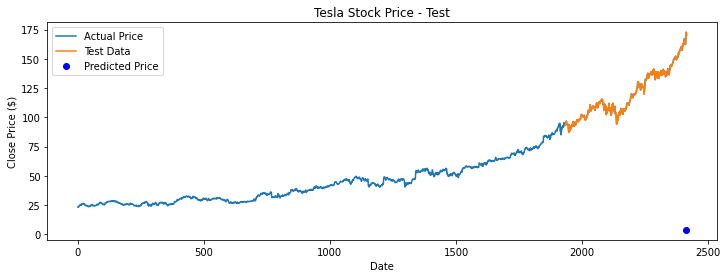

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(data, label='Actual Price')
plt.plot(test_data_plot, label='Test Data')
# Get the predicted price using the model
pred_price = model.predict(test_data)

# Plot the predicted price
plt.plot(len(data) - 1, pred_price[0, 0], 'bo', label='Predicted Price')

plt.title('Tesla Stock Price - Test')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test_data, pred_price)
rmse = np.sqrt(mean_squared_error(test_data, pred_price))

print('MAE:', mae)
print('RMSE:', rmse)

MAE: 116.22966207826113
RMSE: 117.94924977473478


In [ ]:
pred_price = scaler.inverse_transform(pred_price.reshape(-1, 1))
test_data = scaler.inverse_transform(test_data.reshape(-1, 1))

In [ ]:
pred_price = model.predict(X_test)
pred_test = scaler.inverse_transform(pred_price)
mae_perc = np.mean(np.abs(pred_test - test_data)/test_data)*100
rmse_perc = np.sqrt(np.mean(np.power((pred_test - test_data),2)/test_data))*100

print("MAEperc: {:.2f}%".format(mae_perc))
print("RMSEperc: {:.2f}%".format(rmse_perc))


1/1 [==============================] - 0s 42ms/step
MAEperc: 98.06%
RMSEperc: 9156.22%
